In [3]:
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the data
data = pd.read_csv('nba_data.csv')

# Assuming 'Salary' is your target, and you want to use stats as features
features = ['G', 'MP', 'FG', '3P', 'FT', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PTS']  # Select relevant stats
X = data[features]
y = data['Salary']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
import torch
from torch.utils.data import DataLoader, Dataset


class NbaSalaryDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create dataset objects
train_dataset = NbaSalaryDataset(X_train, y_train)
test_dataset = NbaSalaryDataset(X_test, y_test)

# Create data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

In [7]:
import torch.nn as nn

class SalaryPredictor(nn.Module):
    def __init__(self, input_size):
        super(SalaryPredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)  # Input layer
        self.fc2 = nn.Linear(128, 64)         # Hidden layer
        self.fc3 = nn.Linear(64, 1)           # Output layer (predicting salary)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)  # No activation in the output layer (regression task)
        return x

# Initialize the model
input_size = X_train.shape[1]  # Number of features
model = SalaryPredictor(input_size)

In [8]:
criterion = nn.MSELoss()  # Mean Squared Error loss for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [16]:
num_epochs = 50
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_train_loss = 0.0
    
    # Training Loop
    for features, labels in train_loader:
        # Forward pass
        predictions = model(features).squeeze()
        loss = criterion(predictions, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()  # Clear gradients
        loss.backward()        # Backpropagate
        optimizer.step()       # Update weights
        
        running_train_loss += loss.item()
    
    # Calculate average training loss for this epoch
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation Loop (use model.eval() to prevent gradient updates)
    model.eval()  
    running_val_loss = 0.0
    with torch.no_grad():  # Disable gradient computation during validation
        for features, labels in test_loader:
            predictions = model(features).squeeze()
            loss = criterion(predictions, labels)
            running_val_loss += loss.item()
    
    avg_val_loss = running_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    # Print epoch statistics
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

Epoch [1/50], Training Loss: 326599693251379.1875, Validation Loss: 330433767494997.3125
Epoch [2/50], Training Loss: 333806770847744.0000, Validation Loss: 330302077534208.0000
Epoch [3/50], Training Loss: 327422338872115.1875, Validation Loss: 330167457153024.0000
Epoch [4/50], Training Loss: 344714719422054.3750, Validation Loss: 330029951090688.0000
Epoch [5/50], Training Loss: 340068685525811.1875, Validation Loss: 329884034050730.6875
Epoch [6/50], Training Loss: 332055096957337.6250, Validation Loss: 329739772362752.0000
Epoch [7/50], Training Loss: 329155089740595.1875, Validation Loss: 329590801869482.6875
Epoch [8/50], Training Loss: 322619998365286.3750, Validation Loss: 329444191371264.0000
Epoch [9/50], Training Loss: 333478375299481.6250, Validation Loss: 329299348073130.6875
Epoch [10/50], Training Loss: 317104027651276.8125, Validation Loss: 329144829913770.6875
Epoch [11/50], Training Loss: 338337122484224.0000, Validation Loss: 328989215642965.3125
Epoch [12/50], Trai

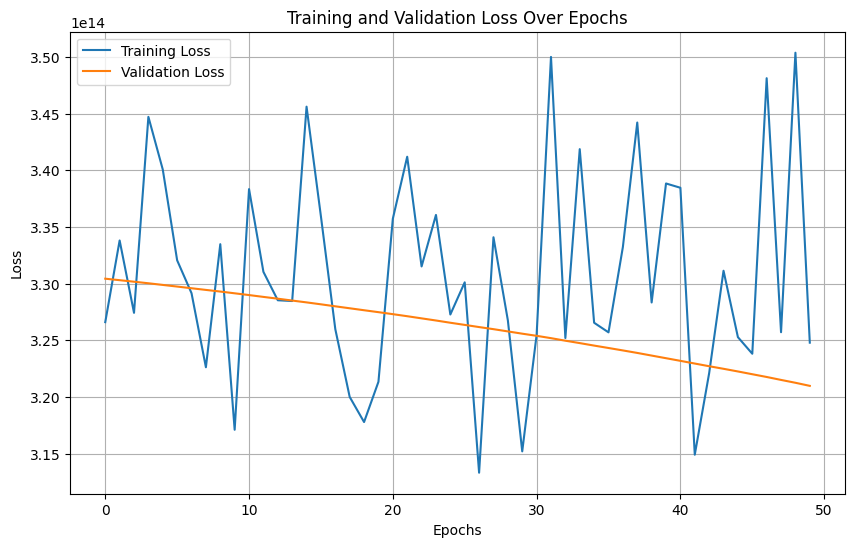

In [17]:
import matplotlib.pyplot as plt
# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    test_loss = 0.0
    for features, labels in test_loader:
        predictions = model(features).squeeze()
        loss = criterion(predictions, labels)
        test_loss += loss.item()
    
    print(f'Test Loss: {test_loss/len(test_loader):.4f}')

Test Loss: 334632523049642.6875
